# Image-to-Image Translation using Conditional GAN 
### Group members


*   Ashutosh Chauhan (S20180010017)
*   Pradum Singh (S20180010136)
*   Vipul Rawat (S20180010192)
*   Ayush Gairola (S20180010020)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
download_data = """mkdir training
cd training
wget http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Original_Images/CUHK_training_sketch.zip
wget http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Original_Images/CUHK_training_photo.zip
unzip CUHK_training_sketch.zip
unzip CUHK_training_photo.zip
rm CUHK_training_photo.zip CUHK_training_sketch.zip
cd ..
mkdir test
cd test
wget http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Original_Images/CUHK_testing_sketch.zip
wget http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Original_Images/CUHK_testing_photo.zip
unzip CUHK_testing_sketch.zip
unzip CUHK_testing_photo.zip
rm CUHK_testing_photo.zip CUHK_testing_sketch.zip
cd .."""
with open("data.sh", 'w') as file:
  file.write(download_data)

!bash data.sh

In [ ]:
import sys
import random
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import Dataset
from torch import optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import glob

In [ ]:
class PhotoSketchDS(Dataset):
  def __init__(self, sketch_paths, photo_paths, transform=None):
    self.sketch_paths = sketch_paths
    self.photo_paths = photo_paths
    self.transform = transform

  def __len__(self):
    return len(self.photo_paths)

  def __getitem__(self, idx):
    sketch_img = Image.open(self.sketch_paths[idx]).convert('RGB')
    photo_img = Image.open(self.photo_paths[idx]).convert('RGB')
    sketch_img = self.transform(sketch_img)
    photo_img = self.transform(photo_img)
    return sketch_img, photo_img

In [ ]:
os.chdir('/content')
PATH = os.getcwd() 
TRAIN_SKETCHES_PATH = PATH +'/training/sketch'
TRAIN_PHOTOS_PATH = PATH + '/training/photo'
TEST_SKETCHES_PATH = PATH + '/test/sketch'
TEST_PHOTOS_PATH = PATH + '/test/photo'

In [ ]:
save_dir = PATH + '/results'
model_dir = PATH + '/models'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print(f"save_dir {save_dir} created")
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print(f"model_dir {model_dir} created")

In [ ]:
TRAIN_SKETCHES_DATA = sorted(glob.glob(TRAIN_SKETCHES_PATH + '/*.jpg'))
TRAIN_PHOTOS_DATA = sorted(glob.glob(TRAIN_PHOTOS_PATH + '/*.jpg'))
TEST_SKETCHES_DATA = sorted(glob.glob(TEST_SKETCHES_PATH + '/*.jpg'))
TEST_PHOTOS_DATA = sorted(glob.glob(TEST_PHOTOS_PATH + '/*.jpg'))

In [ ]:
print(f"Len Train Data: {len(TRAIN_SKETCHES_DATA)}")
print(f"Len Test Data: {len(TEST_SKETCHES_DATA)}")

Len Train Data: 88
Len Test Data: 100


In [ ]:
EPOCHS = 200
BATCH_SIZE = 10
input_dim = 3
real_dim = 3
LR = 0.0001
display_step=200
target_shape = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data_transform = transforms.Compose([
        # transforms.RandomSizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize((0.5), (0.5))
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
    ])

In [ ]:
dataset_train = PhotoSketchDS(TRAIN_SKETCHES_DATA, TRAIN_PHOTOS_DATA, data_transform) 
dataloader_train = DataLoader(dataset_train, BATCH_SIZE)

In [ ]:
dataset_test = PhotoSketchDS(TEST_SKETCHES_DATA, TEST_PHOTOS_DATA, data_transform) 
dataloader_test = DataLoader(dataset_test, BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


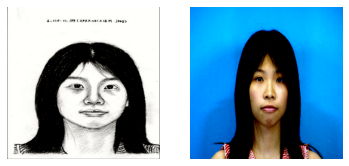

In [ ]:
for batch_idx, data in enumerate(dataloader_train):
  sketch, photo = data
  sketch = sketch[0].permute(1, 2, 0)
  photo = photo[0].permute(1, 2, 0)
  plt.subplot(121), plt.imshow(np.squeeze(sketch), cmap='gray'), plt.axis('off')
  plt.subplot(122), plt.imshow(photo.numpy()), plt.axis('off')
  break 

In [ ]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [ ]:

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

In [ ]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x


In [ ]:

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)


In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        #### START CODE HERE ####
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

In [ ]:
def get_gen_loss(generator, discriminator, photo, sketch, adv_criterion, recon_criterion, lambda_recon):
  fake_img = generator(sketch)
  disc_op = discriminator(fake_img, sketch)

  gen_adv_loss = adv_criterion(disc_op, torch.ones_like(disc_op))
  gen_rec_loss = recon_criterion(photo, fake_img)
  gen_loss = gen_adv_loss + lambda_recon*gen_rec_loss

  return gen_loss

In [ ]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image


In [ ]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

In [ ]:
generator = UNet(input_dim, real_dim).to(device)
discriminator = Discriminator(input_dim + real_dim).to(device)

In [ ]:
gen_opt = optim.Adam(generator.parameters(), lr=LR)
disc_opt = optim.Adam(generator.parameters(), lr=LR)
loss = nn.BCELoss()

pretrained = False
step = 1600
if pretrained:
    loaded_state = torch.load(model_dir + f"/cGAN_{step}.pth")
    
    generator.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    discriminator.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
    print(f"cGAN_{step}.pth loaded")
else:
  generator = generator.apply(weights_init)
  discriminator = discriminator.apply(weights_init)

In [ ]:
def train(save_model=True):
  g_loss = []
  d_loss = []
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  cur_step = 0
  for epoch in tqdm(range(EPOCHS), total=EPOCHS):

    time0 = time.time()

    # print(f"epoch: {epoch} ")

    for batch_idx, data in (enumerate(dataloader_train)):
      sketch, photo = data
      sketch = sketch.to(device)
      photo = photo.to(device)

      disc_opt.zero_grad()
      with torch.no_grad():
        fake = generator(sketch)
      
      # Update Discriminator
      disc_fake_hat = discriminator(fake.detach(), sketch)
      disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
      
      disc_real_hat = discriminator(photo, sketch)
      disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))

      disc_loss = (disc_fake_loss + disc_real_loss)/2

      disc_loss.backward(retain_graph=True)
      disc_opt.step()

      # Update generator 
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(generator, discriminator, photo, sketch, adv_criterion, recon_criterion, lambda_recon)
      gen_loss.backward() # Update gradients
      gen_opt.step() # Update optimizer

      # Keep track of the average discriminator loss
      mean_discriminator_loss += disc_loss.item() / display_step
      # Keep track of the average generator loss
      mean_generator_loss += gen_loss.item() / display_step

      g_loss.append(mean_generator_loss)
      d_loss.append(mean_discriminator_loss)

      ### Visualization code ###
      if cur_step % display_step == 0:
        if cur_step > 0:
          print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        else:
          print("Pretrained initial state")
        show_tensor_images(sketch, size=(input_dim, target_shape, target_shape))
        show_tensor_images(photo, size=(real_dim, target_shape, target_shape))
        show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        # You can change save_model to True if you'd like to save the model
        if save_model:
            torch.save({'gen': generator.state_dict(),
                'gen_opt': gen_opt.state_dict(),
                'disc': discriminator.state_dict(),
                'disc_opt': disc_opt.state_dict()
            }, model_dir + f"cGAN_{cur_step}.pth")
      cur_step += 1

    time1 = time.time()
    print(f"\ntime for epoch {epoch+1} : {time1-time0} \n step: {cur_step}")


  0%|          | 0/200 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pretrained initial state


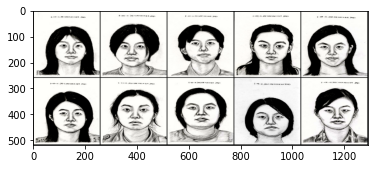

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


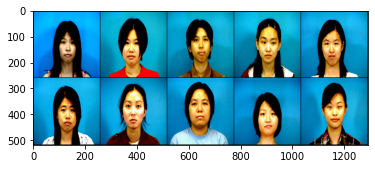

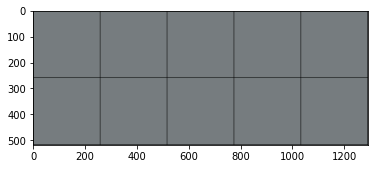

  0%|          | 1/200 [00:16<53:29, 16.13s/it]


time for epoch 1 : 16.129340648651123 
 step: 9


  1%|          | 2/200 [00:26<47:08, 14.29s/it]


time for epoch 2 : 9.985750436782837 
 step: 18


  2%|▏         | 3/200 [00:36<42:40, 13.00s/it]


time for epoch 3 : 9.98543381690979 
 step: 27


  2%|▏         | 4/200 [00:46<39:32, 12.10s/it]


time for epoch 4 : 10.017499685287476 
 step: 36


  2%|▎         | 5/200 [00:56<37:20, 11.49s/it]


time for epoch 5 : 10.061069965362549 
 step: 45


  3%|▎         | 6/200 [01:06<35:52, 11.09s/it]


time for epoch 6 : 10.162584066390991 
 step: 54


  4%|▎         | 7/200 [01:16<34:49, 10.82s/it]


time for epoch 7 : 10.195222616195679 
 step: 63


  4%|▍         | 8/200 [01:26<34:05, 10.65s/it]


time for epoch 8 : 10.253441095352173 
 step: 72


  4%|▍         | 9/200 [01:37<33:33, 10.54s/it]


time for epoch 9 : 10.286898612976074 
 step: 81


  5%|▌         | 10/200 [01:47<33:08, 10.47s/it]


time for epoch 10 : 10.279944658279419 
 step: 90


  6%|▌         | 11/200 [01:57<32:50, 10.43s/it]


time for epoch 11 : 10.330307483673096 
 step: 99


  6%|▌         | 12/200 [02:08<32:36, 10.41s/it]


time for epoch 12 : 10.361683130264282 
 step: 108


  6%|▋         | 13/200 [02:18<32:23, 10.39s/it]


time for epoch 13 : 10.358404397964478 
 step: 117


  7%|▋         | 14/200 [02:28<32:11, 10.39s/it]


time for epoch 14 : 10.367148399353027 
 step: 126


  8%|▊         | 15/200 [02:39<32:10, 10.43s/it]


time for epoch 15 : 10.540625810623169 
 step: 135


  8%|▊         | 16/200 [02:50<32:22, 10.55s/it]


time for epoch 16 : 10.836005687713623 
 step: 144


  8%|▊         | 17/200 [03:01<32:36, 10.69s/it]


time for epoch 17 : 11.018020868301392 
 step: 153


  9%|▉         | 18/200 [03:12<32:48, 10.81s/it]


time for epoch 18 : 11.094067573547363 
 step: 162


 10%|▉         | 19/200 [03:23<32:43, 10.85s/it]


time for epoch 19 : 10.925468683242798 
 step: 171


 10%|█         | 20/200 [03:34<32:29, 10.83s/it]


time for epoch 20 : 10.789859533309937 
 step: 180


 10%|█         | 21/200 [03:44<32:10, 10.79s/it]


time for epoch 21 : 10.677919626235962 
 step: 189


 11%|█         | 22/200 [03:55<31:52, 10.74s/it]


time for epoch 22 : 10.646535396575928 
 step: 198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 22: Step 200: Generator (U-Net) loss: 79.29791477203374, Discriminator loss: 0.6931513339281089


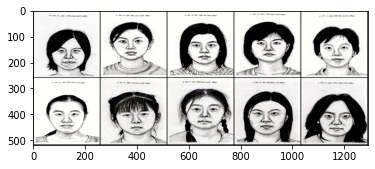

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


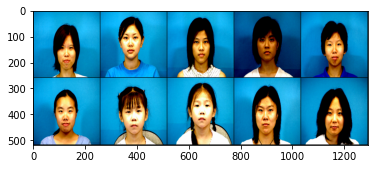

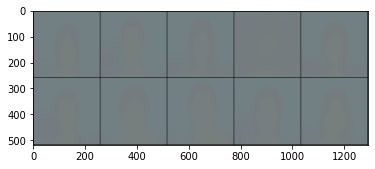

 12%|█▏        | 23/200 [04:17<41:31, 14.07s/it]


time for epoch 23 : 21.842156171798706 
 step: 207


 12%|█▏        | 24/200 [04:27<38:21, 13.08s/it]


time for epoch 24 : 10.749724626541138 
 step: 216


 12%|█▎        | 25/200 [04:38<36:18, 12.45s/it]


time for epoch 25 : 10.979644060134888 
 step: 225


 13%|█▎        | 26/200 [04:49<34:51, 12.02s/it]


time for epoch 26 : 11.023842811584473 
 step: 234


 14%|█▎        | 27/200 [05:00<33:41, 11.68s/it]


time for epoch 27 : 10.892952680587769 
 step: 243


 14%|█▍        | 28/200 [05:11<32:41, 11.40s/it]


time for epoch 28 : 10.743859767913818 
 step: 252


 14%|█▍        | 29/200 [05:22<31:54, 11.20s/it]


time for epoch 29 : 10.7160964012146 
 step: 261


 15%|█▌        | 30/200 [05:32<31:14, 11.02s/it]


time for epoch 30 : 10.618481159210205 
 step: 270


 16%|█▌        | 31/200 [05:43<30:46, 10.92s/it]


time for epoch 31 : 10.690239906311035 
 step: 279


 16%|█▌        | 32/200 [05:54<30:26, 10.87s/it]


time for epoch 32 : 10.747844219207764 
 step: 288


 16%|█▋        | 33/200 [06:05<30:09, 10.84s/it]


time for epoch 33 : 10.748740673065186 
 step: 297


 17%|█▋        | 34/200 [06:15<29:56, 10.82s/it]


time for epoch 34 : 10.787806987762451 
 step: 306


 18%|█▊        | 35/200 [06:26<29:44, 10.81s/it]


time for epoch 35 : 10.78814148902893 
 step: 315


 18%|█▊        | 36/200 [06:37<29:34, 10.82s/it]


time for epoch 36 : 10.830169677734375 
 step: 324


 18%|█▊        | 37/200 [06:48<29:21, 10.81s/it]


time for epoch 37 : 10.777942419052124 
 step: 333


 19%|█▉        | 38/200 [06:59<29:09, 10.80s/it]


time for epoch 38 : 10.77451753616333 
 step: 342


 20%|█▉        | 39/200 [07:09<28:56, 10.78s/it]


time for epoch 39 : 10.749493598937988 
 step: 351


 20%|██        | 40/200 [07:20<28:43, 10.77s/it]


time for epoch 40 : 10.74224305152893 
 step: 360


 20%|██        | 41/200 [07:31<28:32, 10.77s/it]


time for epoch 41 : 10.765121221542358 
 step: 369


 21%|██        | 42/200 [07:42<28:20, 10.76s/it]


time for epoch 42 : 10.738902807235718 
 step: 378


 22%|██▏       | 43/200 [07:52<28:08, 10.75s/it]


time for epoch 43 : 10.729278087615967 
 step: 387


 22%|██▏       | 44/200 [08:03<27:58, 10.76s/it]


time for epoch 44 : 10.765007495880127 
 step: 396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 44: Step 400: Generator (U-Net) loss: 76.41749053955081, Discriminator loss: 0.6931513202190402


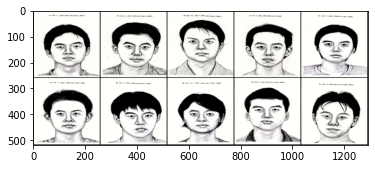

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


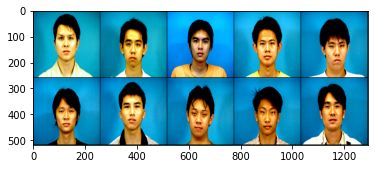

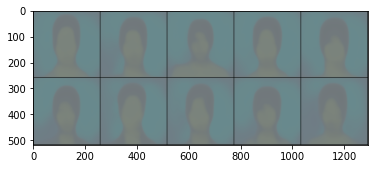

 22%|██▎       | 45/200 [08:24<36:00, 13.94s/it]


time for epoch 45 : 21.35380721092224 
 step: 405


 23%|██▎       | 46/200 [08:35<33:18, 12.98s/it]


time for epoch 46 : 10.743956804275513 
 step: 414


 24%|██▎       | 47/200 [08:46<31:34, 12.38s/it]


time for epoch 47 : 10.979523181915283 
 step: 423


 24%|██▍       | 48/200 [08:57<30:17, 11.96s/it]


time for epoch 48 : 10.977954626083374 
 step: 432


 24%|██▍       | 49/200 [09:08<29:16, 11.64s/it]


time for epoch 49 : 10.878511905670166 
 step: 441


 25%|██▌       | 50/200 [09:19<28:28, 11.39s/it]


time for epoch 50 : 10.806741714477539 
 step: 450


 26%|██▌       | 51/200 [09:30<27:47, 11.19s/it]


time for epoch 51 : 10.735571146011353 
 step: 459


 26%|██▌       | 52/200 [09:40<27:15, 11.05s/it]


time for epoch 52 : 10.706993818283081 
 step: 468


 26%|██▋       | 53/200 [09:51<26:48, 10.94s/it]


time for epoch 53 : 10.696268081665039 
 step: 477


 27%|██▋       | 54/200 [10:02<26:29, 10.89s/it]


time for epoch 54 : 10.761620998382568 
 step: 486


 28%|██▊       | 55/200 [10:13<26:14, 10.86s/it]


time for epoch 55 : 10.789169073104858 
 step: 495


 28%|██▊       | 56/200 [10:23<26:01, 10.84s/it]


time for epoch 56 : 10.80431079864502 
 step: 504


 28%|██▊       | 57/200 [10:34<25:49, 10.84s/it]


time for epoch 57 : 10.822182655334473 
 step: 513


 29%|██▉       | 58/200 [10:45<25:35, 10.82s/it]


time for epoch 58 : 10.76282000541687 
 step: 522


 30%|██▉       | 59/200 [10:56<25:21, 10.79s/it]


time for epoch 59 : 10.732632637023926 
 step: 531


 30%|███       | 60/200 [11:06<25:08, 10.77s/it]


time for epoch 60 : 10.734946489334106 
 step: 540


 30%|███       | 61/200 [11:17<24:59, 10.79s/it]


time for epoch 61 : 10.815577745437622 
 step: 549


 31%|███       | 62/200 [11:28<24:48, 10.78s/it]


time for epoch 62 : 10.771773099899292 
 step: 558


 32%|███▏      | 63/200 [11:39<24:35, 10.77s/it]


time for epoch 63 : 10.737750768661499 
 step: 567


 32%|███▏      | 64/200 [11:50<24:25, 10.78s/it]


time for epoch 64 : 10.790369272232056 
 step: 576


 32%|███▎      | 65/200 [12:00<24:14, 10.77s/it]


time for epoch 65 : 10.756142139434814 
 step: 585


 33%|███▎      | 66/200 [12:11<24:03, 10.78s/it]


time for epoch 66 : 10.783080577850342 
 step: 594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 66: Step 600: Generator (U-Net) loss: 71.52806318283086, Discriminator loss: 0.693151296973228


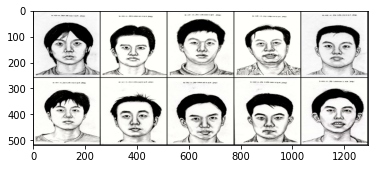

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


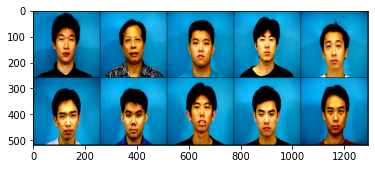

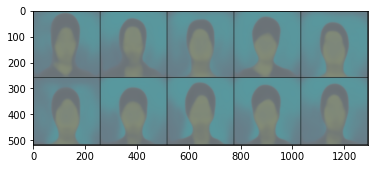

 34%|███▎      | 67/200 [12:33<31:12, 14.08s/it]


time for epoch 67 : 21.786086559295654 
 step: 603


 34%|███▍      | 68/200 [12:44<28:42, 13.05s/it]


time for epoch 68 : 10.654442071914673 
 step: 612


 34%|███▍      | 69/200 [12:54<27:03, 12.39s/it]


time for epoch 69 : 10.858295917510986 
 step: 621


 35%|███▌      | 70/200 [13:05<25:59, 11.99s/it]


time for epoch 70 : 11.053853034973145 
 step: 630


 36%|███▌      | 71/200 [13:16<25:07, 11.69s/it]


time for epoch 71 : 10.973639011383057 
 step: 639


 36%|███▌      | 72/200 [13:27<24:22, 11.42s/it]


time for epoch 72 : 10.799144268035889 
 step: 648


 36%|███▋      | 73/200 [13:38<23:43, 11.21s/it]


time for epoch 73 : 10.70348048210144 
 step: 657


 37%|███▋      | 74/200 [13:49<23:13, 11.06s/it]


time for epoch 74 : 10.704135417938232 
 step: 666


 38%|███▊      | 75/200 [13:59<22:48, 10.95s/it]


time for epoch 75 : 10.689916372299194 
 step: 675


 38%|███▊      | 76/200 [14:10<22:30, 10.89s/it]


time for epoch 76 : 10.746194839477539 
 step: 684


 38%|███▊      | 77/200 [14:21<22:16, 10.86s/it]


time for epoch 77 : 10.801201105117798 
 step: 693


 39%|███▉      | 78/200 [14:32<22:02, 10.84s/it]


time for epoch 78 : 10.78186583518982 
 step: 702


 40%|███▉      | 79/200 [14:43<21:53, 10.86s/it]


time for epoch 79 : 10.892938137054443 
 step: 711


 40%|████      | 80/200 [14:53<21:41, 10.85s/it]


time for epoch 80 : 10.830347776412964 
 step: 720


 40%|████      | 81/200 [15:04<21:29, 10.84s/it]


time for epoch 81 : 10.806195497512817 
 step: 729


 41%|████      | 82/200 [15:15<21:20, 10.85s/it]


time for epoch 82 : 10.871464967727661 
 step: 738


 42%|████▏     | 83/200 [15:26<21:08, 10.84s/it]


time for epoch 83 : 10.820085525512695 
 step: 747


 42%|████▏     | 84/200 [15:37<20:58, 10.85s/it]


time for epoch 84 : 10.872071743011475 
 step: 756


 42%|████▎     | 85/200 [15:48<20:48, 10.86s/it]


time for epoch 85 : 10.868391513824463 
 step: 765


 43%|████▎     | 86/200 [15:58<20:36, 10.85s/it]


time for epoch 86 : 10.836045980453491 
 step: 774


 44%|████▎     | 87/200 [16:09<20:25, 10.85s/it]


time for epoch 87 : 10.844807147979736 
 step: 783


 44%|████▍     | 88/200 [16:20<20:15, 10.85s/it]


time for epoch 88 : 10.851753234863281 
 step: 792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 88: Step 800: Generator (U-Net) loss: 65.458732585907, Discriminator loss: 0.6931512361764907


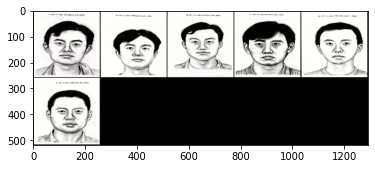

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


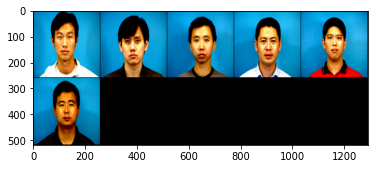

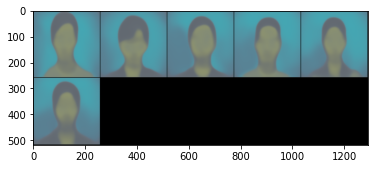

 44%|████▍     | 89/200 [16:42<26:04, 14.09s/it]


time for epoch 89 : 21.654303550720215 
 step: 801


 45%|████▌     | 90/200 [16:52<23:57, 13.07s/it]


time for epoch 90 : 10.679708003997803 
 step: 810


 46%|████▌     | 91/200 [17:03<22:28, 12.37s/it]


time for epoch 91 : 10.737207412719727 
 step: 819


 46%|████▌     | 92/200 [17:14<21:31, 11.96s/it]


time for epoch 92 : 10.990901708602905 
 step: 828


 46%|████▋     | 93/200 [17:25<20:47, 11.66s/it]


time for epoch 93 : 10.951212167739868 
 step: 837


 47%|████▋     | 94/200 [17:36<20:09, 11.41s/it]


time for epoch 94 : 10.833442687988281 
 step: 846


 48%|████▊     | 95/200 [17:47<19:38, 11.22s/it]


time for epoch 95 : 10.785220861434937 
 step: 855


 48%|████▊     | 96/200 [17:57<19:09, 11.06s/it]


time for epoch 96 : 10.668790102005005 
 step: 864


 48%|████▊     | 97/200 [18:08<18:48, 10.96s/it]


time for epoch 97 : 10.731538534164429 
 step: 873


 49%|████▉     | 98/200 [18:19<18:31, 10.90s/it]


time for epoch 98 : 10.759604692459106 
 step: 882


 50%|████▉     | 99/200 [18:30<18:18, 10.88s/it]


time for epoch 99 : 10.828588724136353 
 step: 891


 50%|█████     | 100/200 [18:41<18:06, 10.87s/it]


time for epoch 100 : 10.83992075920105 
 step: 900


 50%|█████     | 101/200 [18:51<17:54, 10.86s/it]


time for epoch 101 : 10.835408926010132 
 step: 909


 51%|█████     | 102/200 [19:02<17:44, 10.86s/it]


time for epoch 102 : 10.86464262008667 
 step: 918


 52%|█████▏    | 103/200 [19:13<17:31, 10.84s/it]


time for epoch 103 : 10.790716171264648 
 step: 927


 52%|█████▏    | 104/200 [19:24<17:18, 10.82s/it]


time for epoch 104 : 10.757473230361938 
 step: 936


 52%|█████▎    | 105/200 [19:35<17:06, 10.80s/it]


time for epoch 105 : 10.770576477050781 
 step: 945


 53%|█████▎    | 106/200 [19:45<16:55, 10.80s/it]


time for epoch 106 : 10.798323392868042 
 step: 954


 54%|█████▎    | 107/200 [19:56<16:43, 10.79s/it]


time for epoch 107 : 10.762323379516602 
 step: 963


 54%|█████▍    | 108/200 [20:07<16:32, 10.79s/it]


time for epoch 108 : 10.786804914474487 
 step: 972


 55%|█████▍    | 109/200 [20:18<16:22, 10.80s/it]


time for epoch 109 : 10.816016674041748 
 step: 981


 55%|█████▌    | 110/200 [20:29<16:13, 10.82s/it]


time for epoch 110 : 10.854805707931519 
 step: 990


 56%|█████▌    | 111/200 [20:40<16:03, 10.82s/it]


time for epoch 111 : 10.835515260696411 
 step: 999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 111: Step 1000: Generator (U-Net) loss: 59.0242687034607, Discriminator loss: 0.6931511333584784


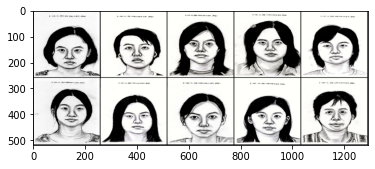

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


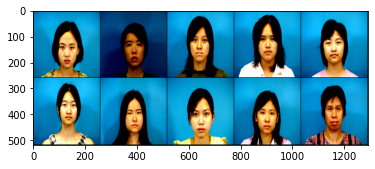

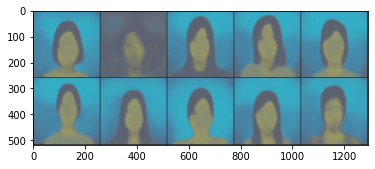

 56%|█████▌    | 112/200 [21:01<20:44, 14.14s/it]


time for epoch 112 : 21.876159191131592 
 step: 1008


 56%|█████▋    | 113/200 [21:12<19:03, 13.15s/it]


time for epoch 113 : 10.830039024353027 
 step: 1017


 57%|█████▋    | 114/200 [21:23<17:58, 12.54s/it]


time for epoch 114 : 11.127034425735474 
 step: 1026


 57%|█████▊    | 115/200 [21:34<17:05, 12.06s/it]


time for epoch 115 : 10.94687819480896 
 step: 1035


 58%|█████▊    | 116/200 [21:45<16:21, 11.68s/it]


time for epoch 116 : 10.78514838218689 
 step: 1044


 58%|█████▊    | 117/200 [21:56<15:45, 11.39s/it]


time for epoch 117 : 10.71826457977295 
 step: 1053


 59%|█████▉    | 118/200 [22:06<15:15, 11.16s/it]


time for epoch 118 : 10.629335403442383 
 step: 1062


 60%|█████▉    | 119/200 [22:17<14:51, 11.01s/it]


time for epoch 119 : 10.649112462997437 
 step: 1071


 60%|██████    | 120/200 [22:28<14:33, 10.92s/it]


time for epoch 120 : 10.69658613204956 
 step: 1080


 60%|██████    | 121/200 [22:39<14:17, 10.85s/it]


time for epoch 121 : 10.704785346984863 
 step: 1089


 61%|██████    | 122/200 [22:49<14:05, 10.84s/it]


time for epoch 122 : 10.807828187942505 
 step: 1098


 62%|██████▏   | 123/200 [23:00<13:54, 10.83s/it]


time for epoch 123 : 10.811907768249512 
 step: 1107


 62%|██████▏   | 124/200 [23:11<13:42, 10.82s/it]


time for epoch 124 : 10.804556846618652 
 step: 1116


 62%|██████▎   | 125/200 [23:22<13:30, 10.80s/it]


time for epoch 125 : 10.755530595779419 
 step: 1125


 63%|██████▎   | 126/200 [23:33<13:20, 10.81s/it]


time for epoch 126 : 10.829612731933594 
 step: 1134


 64%|██████▎   | 127/200 [23:43<13:08, 10.80s/it]


time for epoch 127 : 10.766667127609253 
 step: 1143


 64%|██████▍   | 128/200 [23:54<12:56, 10.79s/it]


time for epoch 128 : 10.758490085601807 
 step: 1152


 64%|██████▍   | 129/200 [24:05<12:45, 10.78s/it]


time for epoch 129 : 10.752744913101196 
 step: 1161


 65%|██████▌   | 130/200 [24:16<12:33, 10.77s/it]


time for epoch 130 : 10.744446992874146 
 step: 1170


 66%|██████▌   | 131/200 [24:26<12:22, 10.76s/it]


time for epoch 131 : 10.743308782577515 
 step: 1179


 66%|██████▌   | 132/200 [24:37<12:12, 10.77s/it]


time for epoch 132 : 10.785391807556152 
 step: 1188


 66%|██████▋   | 133/200 [24:48<12:01, 10.76s/it]


time for epoch 133 : 10.74464201927185 
 step: 1197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 133: Step 1200: Generator (U-Net) loss: 52.59108917236328, Discriminator loss: 0.6931510409712797


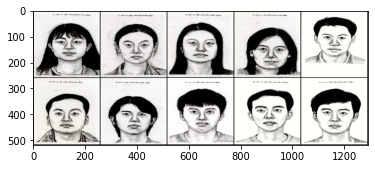

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


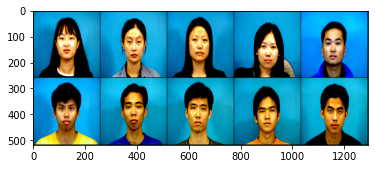

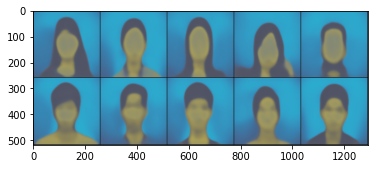

 67%|██████▋   | 134/200 [25:09<15:26, 14.03s/it]


time for epoch 134 : 21.65952205657959 
 step: 1206


 68%|██████▊   | 135/200 [25:20<14:08, 13.05s/it]


time for epoch 135 : 10.76236081123352 
 step: 1215


 68%|██████▊   | 136/200 [25:31<13:15, 12.44s/it]


time for epoch 136 : 10.998632192611694 
 step: 1224


 68%|██████▊   | 137/200 [25:42<12:36, 12.01s/it]


time for epoch 137 : 11.027409315109253 
 step: 1233


 69%|██████▉   | 138/200 [25:53<12:03, 11.67s/it]


time for epoch 138 : 10.874114513397217 
 step: 1242


 70%|██████▉   | 139/200 [26:04<11:35, 11.41s/it]


time for epoch 139 : 10.781347751617432 
 step: 1251


 70%|███████   | 140/200 [26:15<11:11, 11.19s/it]


time for epoch 140 : 10.699981689453125 
 step: 1260


 70%|███████   | 141/200 [26:25<10:50, 11.03s/it]


time for epoch 141 : 10.639581203460693 
 step: 1269


 71%|███████   | 142/200 [26:36<10:34, 10.94s/it]


time for epoch 142 : 10.727459907531738 
 step: 1278


 72%|███████▏  | 143/200 [26:47<10:20, 10.89s/it]


time for epoch 143 : 10.781853199005127 
 step: 1287


 72%|███████▏  | 144/200 [26:58<10:08, 10.87s/it]


time for epoch 144 : 10.823769569396973 
 step: 1296


 72%|███████▎  | 145/200 [27:08<09:57, 10.87s/it]


time for epoch 145 : 10.848337888717651 
 step: 1305


 73%|███████▎  | 146/200 [27:19<09:45, 10.84s/it]


time for epoch 146 : 10.789470911026001 
 step: 1314


 74%|███████▎  | 147/200 [27:30<09:33, 10.82s/it]


time for epoch 147 : 10.778266191482544 
 step: 1323


 74%|███████▍  | 148/200 [27:41<09:21, 10.79s/it]


time for epoch 148 : 10.701718091964722 
 step: 1332


 74%|███████▍  | 149/200 [27:51<09:08, 10.76s/it]


time for epoch 149 : 10.697678327560425 
 step: 1341


 75%|███████▌  | 150/200 [28:02<08:58, 10.76s/it]


time for epoch 150 : 10.769355535507202 
 step: 1350


 76%|███████▌  | 151/200 [28:13<08:46, 10.75s/it]


time for epoch 151 : 10.703566312789917 
 step: 1359


 76%|███████▌  | 152/200 [28:24<08:35, 10.75s/it]


time for epoch 152 : 10.753308057785034 
 step: 1368


 76%|███████▋  | 153/200 [28:34<08:25, 10.76s/it]


time for epoch 153 : 10.785396575927734 
 step: 1377


 77%|███████▋  | 154/200 [28:45<08:15, 10.78s/it]


time for epoch 154 : 10.816721677780151 
 step: 1386


 78%|███████▊  | 155/200 [28:56<08:05, 10.78s/it]


time for epoch 155 : 10.783843517303467 
 step: 1395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 155: Step 1400: Generator (U-Net) loss: 46.97334093093869, Discriminator loss: 0.6931509524583815


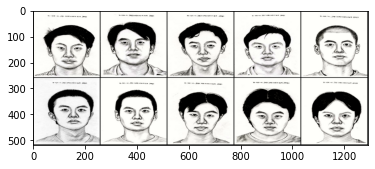

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


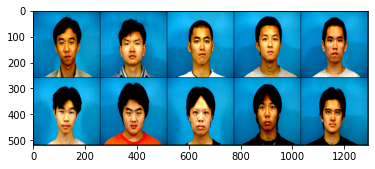

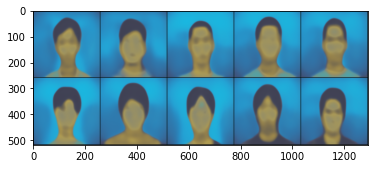

 78%|███████▊  | 156/200 [29:18<10:18, 14.05s/it]


time for epoch 156 : 21.67363214492798 
 step: 1404


 78%|███████▊  | 157/200 [29:28<09:20, 13.04s/it]


time for epoch 157 : 10.692550897598267 
 step: 1413


 79%|███████▉  | 158/200 [29:39<08:41, 12.42s/it]


time for epoch 158 : 10.970921993255615 
 step: 1422


 80%|███████▉  | 159/200 [29:51<08:13, 12.03s/it]


time for epoch 159 : 11.101273775100708 
 step: 1431


 80%|████████  | 160/200 [30:01<07:47, 11.69s/it]


time for epoch 160 : 10.9050133228302 
 step: 1440


 80%|████████  | 161/200 [30:12<07:25, 11.42s/it]


time for epoch 161 : 10.788245439529419 
 step: 1449


 81%|████████  | 162/200 [30:23<07:06, 11.22s/it]


time for epoch 162 : 10.735739946365356 
 step: 1458


 82%|████████▏ | 163/200 [30:34<06:48, 11.05s/it]


time for epoch 163 : 10.670620918273926 
 step: 1467


 82%|████████▏ | 164/200 [30:44<06:33, 10.94s/it]


time for epoch 164 : 10.666849374771118 
 step: 1476


 82%|████████▎ | 165/200 [30:55<06:19, 10.84s/it]


time for epoch 165 : 10.61723804473877 
 step: 1485


 83%|████████▎ | 166/200 [31:06<06:07, 10.81s/it]


time for epoch 166 : 10.727370738983154 
 step: 1494


 84%|████████▎ | 167/200 [31:16<05:56, 10.79s/it]


time for epoch 167 : 10.74523138999939 
 step: 1503


 84%|████████▍ | 168/200 [31:27<05:44, 10.76s/it]


time for epoch 168 : 10.674529314041138 
 step: 1512


 84%|████████▍ | 169/200 [31:38<05:32, 10.71s/it]


time for epoch 169 : 10.600018739700317 
 step: 1521


 85%|████████▌ | 170/200 [31:48<05:20, 10.69s/it]


time for epoch 170 : 10.628634214401245 
 step: 1530


 86%|████████▌ | 171/200 [31:59<05:09, 10.67s/it]


time for epoch 171 : 10.616887331008911 
 step: 1539


 86%|████████▌ | 172/200 [32:10<04:58, 10.65s/it]


time for epoch 172 : 10.614835500717163 
 step: 1548


 86%|████████▋ | 173/200 [32:20<04:47, 10.66s/it]


time for epoch 173 : 10.677039384841919 
 step: 1557


 87%|████████▋ | 174/200 [32:31<04:37, 10.66s/it]


time for epoch 174 : 10.670412540435791 
 step: 1566


 88%|████████▊ | 175/200 [32:42<04:27, 10.69s/it]


time for epoch 175 : 10.74378776550293 
 step: 1575


 88%|████████▊ | 176/200 [32:52<04:16, 10.70s/it]


time for epoch 176 : 10.733210325241089 
 step: 1584


 88%|████████▊ | 177/200 [33:03<04:06, 10.71s/it]


time for epoch 177 : 10.712069034576416 
 step: 1593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 177: Step 1600: Generator (U-Net) loss: 42.76176553726195, Discriminator loss: 0.6931508341431616


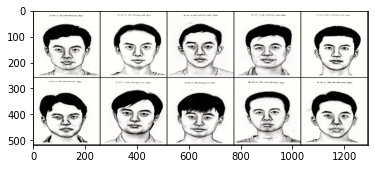

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


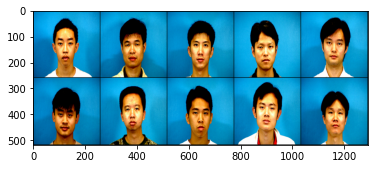

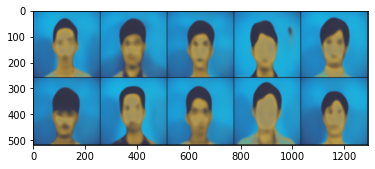

 89%|████████▉ | 178/200 [33:25<05:07, 13.98s/it]


time for epoch 178 : 21.60354709625244 
 step: 1602


 90%|████████▉ | 179/200 [33:35<04:32, 12.96s/it]


time for epoch 179 : 10.592371702194214 
 step: 1611


 90%|█████████ | 180/200 [33:46<04:06, 12.32s/it]


time for epoch 180 : 10.809974431991577 
 step: 1620


 90%|█████████ | 181/200 [33:57<03:46, 11.94s/it]


time for epoch 181 : 11.076555490493774 
 step: 1629


 91%|█████████ | 182/200 [34:08<03:29, 11.62s/it]


time for epoch 182 : 10.86488962173462 
 step: 1638


 92%|█████████▏| 183/200 [34:19<03:13, 11.37s/it]


time for epoch 183 : 10.779430389404297 
 step: 1647


 92%|█████████▏| 184/200 [34:30<02:58, 11.18s/it]


time for epoch 184 : 10.751884698867798 
 step: 1656


 92%|█████████▎| 185/200 [34:40<02:45, 11.03s/it]


time for epoch 185 : 10.66072392463684 
 step: 1665


 93%|█████████▎| 186/200 [34:51<02:32, 10.91s/it]


time for epoch 186 : 10.644737958908081 
 step: 1674


 94%|█████████▎| 187/200 [35:02<02:20, 10.84s/it]


time for epoch 187 : 10.663591861724854 
 step: 1683


 94%|█████████▍| 188/200 [35:12<02:09, 10.80s/it]


time for epoch 188 : 10.719322204589844 
 step: 1692


 94%|█████████▍| 189/200 [35:23<01:58, 10.81s/it]


time for epoch 189 : 10.82171630859375 
 step: 1701


 95%|█████████▌| 190/200 [35:34<01:47, 10.80s/it]


time for epoch 190 : 10.775428056716919 
 step: 1710


 96%|█████████▌| 191/200 [35:45<01:37, 10.81s/it]


time for epoch 191 : 10.824870347976685 
 step: 1719


 96%|█████████▌| 192/200 [35:56<01:26, 10.83s/it]


time for epoch 192 : 10.875713109970093 
 step: 1728


 96%|█████████▋| 193/200 [36:06<01:15, 10.85s/it]


time for epoch 193 : 10.901803255081177 
 step: 1737


 97%|█████████▋| 194/200 [36:17<01:05, 10.84s/it]


time for epoch 194 : 10.817003011703491 
 step: 1746


 98%|█████████▊| 195/200 [36:28<00:54, 10.84s/it]


time for epoch 195 : 10.822903156280518 
 step: 1755


 98%|█████████▊| 196/200 [36:39<00:43, 10.82s/it]


time for epoch 196 : 10.763700723648071 
 step: 1764


 98%|█████████▊| 197/200 [36:50<00:32, 10.81s/it]


time for epoch 197 : 10.78312373161316 
 step: 1773


 99%|█████████▉| 198/200 [37:00<00:21, 10.80s/it]


time for epoch 198 : 10.774172306060791 
 step: 1782


100%|█████████▉| 199/200 [37:11<00:10, 10.79s/it]


time for epoch 199 : 10.779313087463379 
 step: 1791


100%|██████████| 200/200 [37:22<00:00, 11.21s/it]


time for epoch 200 : 10.794107913970947 
 step: 1800
CPU times: user 22min 1s, sys: 14min 40s, total: 36min 41s
Wall time: 37min 22s


In [ ]:
%%time
train()